In [ ]:

import os
from pathlib import Path


cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

print("Working dir:", Path.cwd())

RAW_PATH   = Path("data/raw/yahoo_raw_snapshot.csv")
CLEAN_PATH = Path("data/processed/clean_timeseries.csv")
OUT_PATH   = Path("data/processed/features.csv")

print("RAW exists?  ", RAW_PATH.exists(), RAW_PATH)
print("CLEAN exists?", CLEAN_PATH.exists(), CLEAN_PATH)


Working dir: c:\Users\15173\Desktop\stock-ts-forecast
RAW exists?   True data\raw\yahoo_raw_snapshot.csv
CLEAN exists? True data\processed\clean_timeseries.csv


In [ ]:

import numpy as np
import pandas as pd

from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)


In [ ]:

df_raw = pd.read_csv(RAW_PATH, header=[0,1], index_col=0, parse_dates=True)

def flatten_ohlcv(df_multi, tickers):
    
    if isinstance(df_multi.columns, pd.MultiIndex):
        level0 = list(df_multi.columns.levels[0])
        if level0 and level0[0] in ["Open","High","Low","Close","Adj Close","Volume"]:
            df_multi = df_multi.swaplevel(0, 1, axis=1).sort_index(axis=1)

    wanted_fields = ["Adj Close","Close","Open","High","Low","Volume"]
    cols = [(t, f) for t in tickers for f in wanted_fields if (t, f) in df_multi.columns]
    if not cols:
        raise ValueError("No OHLCV columns found. Inspect df_raw.columns.")
    flat = df_multi[cols].copy()
    flat.columns = [f"{t}_{f.replace(' ','')}" for (t, f) in cols]
    return flat

tickers = ["AAPL","SPY","^VIX"]
ohlcv = flatten_ohlcv(df_raw, tickers)
print("ohlcv shape:", ohlcv.shape)
ohlcv.head()


ohlcv shape: (3484, 16)


,AAPL_Close,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Volume,SPY_AdjClose,SPY_Close,SPY_Open,SPY_High,SPY_Low,SPY_Volume,^VIX_Close,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Volume
Date,,,,,,,,,,,,,,,,
2012-01-03,12.345172,12.290236,12.383298,12.278228,302220800,NaN,NaN,NaN,NaN,NaN,NaN,22.969999,22.950001,23.100000,22.540001,0
2012-01-04,12.411514,12.308245,12.448740,12.286631,260022000,NaN,NaN,NaN,NaN,NaN,NaN,22.219999,23.440001,23.730000,22.219999,0
2012-01-05,12.549309,12.456847,12.564919,12.388400,271269600,NaN,NaN,NaN,NaN,NaN,NaN,21.480000,22.750000,23.090000,21.340000,0
2012-01-06,12.680498,12.601545,12.691005,12.585034,318292800,NaN,NaN,NaN,NaN,NaN,NaN,20.629999,21.240000,21.719999,20.580000,0
2012-01-09,12.660383,12.773560,12.841104,12.648975,394024400,NaN,NaN,NaN,NaN,NaN,NaN,21.070000,21.670000,21.780001,21.000000,0


In [ ]:
def pick_price(df, prefix):
    if f"{prefix}_AdjClose" in df.columns: return f"{prefix}_AdjClose"
    if f"{prefix}_Close"    in df.columns: return f"{prefix}_Close"
    raise ValueError(f"Missing price cols for {prefix}")

AAPL_PRICE = pick_price(ohlcv, "AAPL")
SPY_PRICE  = pick_price(ohlcv, "SPY")
VIX_PRICE  = "VIX_AdjClose" if "VIX_AdjClose" in ohlcv.columns else ("VIX_Close" if "VIX_Close" in ohlcv.columns else None)
AAPL_PRICE, SPY_PRICE, VIX_PRICE


('AAPL_Close', 'SPY_AdjClose', None)

In [ ]:
feat = ohlcv.copy()

# daily log-returns
feat["AAPL_log_ret"] = np.log(feat[AAPL_PRICE] / feat[AAPL_PRICE].shift(1))
feat["SPY_log_ret"]  = np.log(feat[SPY_PRICE]  / feat[SPY_PRICE].shift(1))

# VIX level & change
if VIX_PRICE:
    feat["VIX_level"]  = feat[VIX_PRICE]
    feat["VIX_change"] = np.log(feat[VIX_PRICE] / feat[VIX_PRICE].shift(1))
else:
    feat["VIX_level"]  = np.nan
    feat["VIX_change"] = np.nan

# helper series
close = feat[AAPL_PRICE]
high  = feat["AAPL_High"]   if "AAPL_High"   in feat.columns else close
low   = feat["AAPL_Low"]    if "AAPL_Low"    in feat.columns else close
vol   = feat["AAPL_Volume"] if "AAPL_Volume" in feat.columns else None

feat[["AAPL_log_ret","SPY_log_ret","VIX_level","VIX_change"]].head()


,AAPL_log_ret,SPY_log_ret,VIX_level,VIX_change
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,NaN,NaN,NaN
2012-01-05,0.011041,NaN,NaN,NaN
2012-01-06,0.010400,NaN,NaN,NaN
2012-01-09,-0.001588,NaN,NaN,NaN


In [ ]:

# Trend
feat["sma_5"]  = SMAIndicator(close, window=5).sma_indicator()
feat["sma_10"] = SMAIndicator(close, window=10).sma_indicator()
feat["sma_20"] = SMAIndicator(close, window=20).sma_indicator()
feat["ema_12"] = EMAIndicator(close, window=12).ema_indicator()
feat["ema_26"] = EMAIndicator(close, window=26).ema_indicator()
macd = MACD(close, window_slow=26, window_fast=12, window_sign=9)
feat["macd"] = macd.macd()
feat["macd_signal"] = macd.macd_signal()
feat["adx_14"] = ADXIndicator(high=high, low=low, close=close, window=14).adx()

# Momentum
feat["rsi_14"] = RSIIndicator(close, window=14).rsi()
stoch = StochasticOscillator(high=high, low=low, close=close, window=14, smooth_window=3)
feat["stoch_k"] = stoch.stoch()
feat["stoch_d"] = stoch.stoch_signal()
feat["roc_10"] = ROCIndicator(close, window=10).roc()

# Volatility
feat["rollstd_10"] = close.pct_change().rolling(10).std()
feat["rollstd_20"] = close.pct_change().rolling(20).std()
feat["atr_14"] = AverageTrueRange(high=high, low=low, close=close, window=14).average_true_range()
bb = BollingerBands(close, window=20, window_dev=2)
feat["bb_percentb"] = bb.bollinger_pband()

# Price/Volume derived
feat["high_low_spread"] = (high - low) / close
feat["volume_change"] = vol.pct_change() if vol is not None else 0.0

feat.iloc[25:30, -12:]  # preview last few new columns


,macd_signal,adx_14,rsi_14,stoch_k,stoch_d,roc_10,rollstd_10,rollstd_20,atr_14,bb_percentb,high_low_spread,volume_change
Date,,,,,,,,,,,,
2012-02-08,NaN,0.000000,83.326453,99.807893,98.583987,6.721040,0.006942,0.016472,0.196245,0.976196,0.014874,0.289878
2012-02-09,NaN,0.000000,87.280667,95.362686,97.779290,10.916911,0.010242,0.017536,0.225263,1.074184,0.032828,1.167778
2012-02-10,NaN,67.947200,87.329754,94.620227,96.596935,10.315684,0.010645,0.017447,0.228621,0.993899,0.018382,-0.286031
2012-02-13,NaN,69.107442,89.006562,97.973325,95.985413,10.946790,0.010973,0.017366,0.234613,1.010024,0.013410,-0.180715
2012-02-14,NaN,70.275990,90.064691,99.849479,97.481010,11.606175,0.010964,0.017387,0.234066,0.996902,0.014839,-0.109853


In [ ]:

feat["next_log_ret"] = feat["AAPL_log_ret"].shift(-1)
feat["next_ret_up"]  = (feat["next_log_ret"] > 0).astype(int)

feat[["AAPL_log_ret","next_log_ret","next_ret_up"]].head(12)


,AAPL_log_ret,next_log_ret,next_ret_up
Date,,,
2012-01-03,NaN,0.005360,1
2012-01-04,0.005360,0.011041,1
2012-01-05,0.011041,0.010400,1
2012-01-06,0.010400,-0.001588,0
2012-01-09,-0.001588,0.003574,1
2012-01-10,0.003574,-0.001632,0
2012-01-11,-0.001632,-0.002749,0
2012-01-12,-0.002749,-0.003757,0
2012-01-13,-0.003757,0.011581,1


In [ ]:

if CLEAN_PATH.exists():
    clean = pd.read_csv(CLEAN_PATH, index_col=0, parse_dates=True)
    merged = feat.join(
        clean[["next_log_ret","next_ret_up"]].rename(columns={
            "next_log_ret":"next_log_ret_clean",
            "next_ret_up":"next_ret_up_clean"
        }),
        how="left"
    )
    # prefer clean labels
    merged["next_log_ret"] = merged["next_log_ret_clean"].fillna(merged["next_log_ret"])
    merged["next_ret_up"]  = merged["next_ret_up_clean"].fillna(merged["next_ret_up"]).astype(int)
    merged = merged.drop(columns=["next_log_ret_clean","next_ret_up_clean"])
else:
    merged = feat

# drop warm-up NaNs caused by rolling windows and shift
merged = merged.dropna(subset=["next_log_ret", "next_ret_up"]).copy()
merged = merged.fillna(method="ffill").fillna(method="bfill")
print("merged shape:", merged.shape)
merged.head()


merged shape: (3483, 40)


C:\Users\15173\AppData\Local\Temp\ipykernel_340236\4007393022.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["next_log_ret"] = merged["next_log_ret_clean"].fillna(merged["next_log_ret"])
C:\Users\15173\AppData\Local\Temp\ipykernel_340236\4007393022.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["next_ret_up"]  = merged["next_ret_up_clean"].fillna(merged["next_ret_up"]).astype(int)
C:\Users\15173\AppData\Local\Temp\ipykernel_340236\4007393022.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a f

,AAPL_Close,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Volume,SPY_AdjClose,SPY_Close,SPY_Open,SPY_High,SPY_Low,...,stoch_d,roc_10,rollstd_10,rollstd_20,atr_14,bb_percentb,high_low_spread,volume_change,next_log_ret,next_ret_up
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.345172,12.290236,12.383298,12.278228,302220800,NaN,NaN,NaN,NaN,NaN,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.008511,-0.139629,0.005360,1
2012-01-04,12.411514,12.308245,12.448740,12.286631,260022000,NaN,NaN,NaN,NaN,NaN,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.013061,-0.139629,0.011041,1
2012-01-05,12.549309,12.456847,12.564919,12.388400,271269600,NaN,NaN,NaN,NaN,NaN,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.014066,0.043256,0.010400,1
2012-01-06,12.680498,12.601545,12.691005,12.585034,318292800,NaN,NaN,NaN,NaN,NaN,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.008357,0.173345,-0.001588,0
2012-01-09,12.660383,12.773560,12.841104,12.648975,394024400,NaN,NaN,NaN,NaN,NaN,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.015176,0.237931,0.003574,1


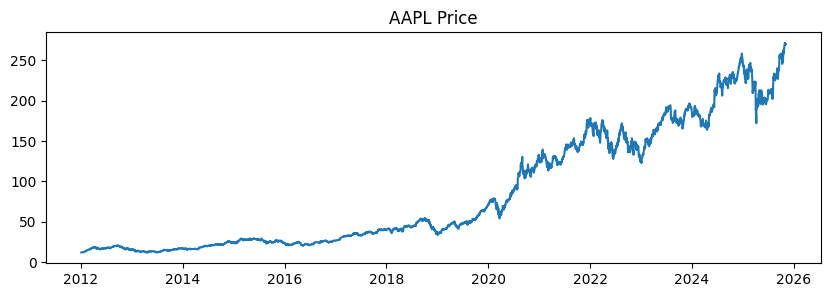

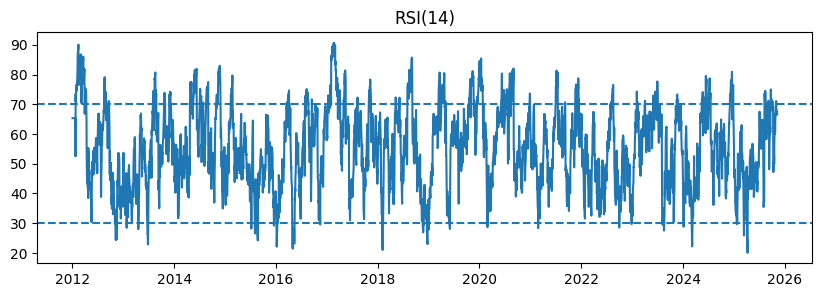

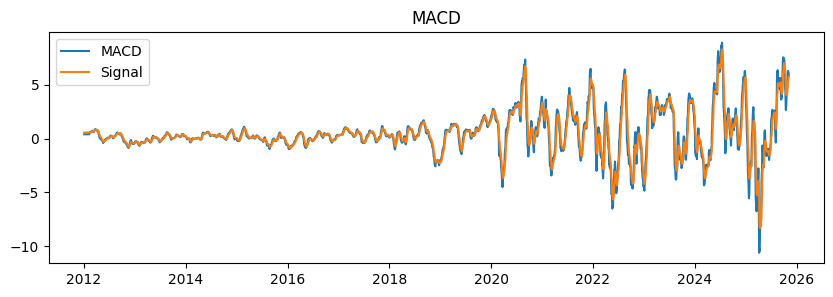

In [ ]:

plt.plot(merged[AAPL_PRICE]); plt.title("AAPL Price"); plt.show()

plt.plot(merged["rsi_14"]); plt.axhline(70, ls="--"); plt.axhline(30, ls="--")
plt.title("RSI(14)"); plt.show()

plt.plot(merged["macd"], label="MACD"); plt.plot(merged["macd_signal"], label="Signal"); plt.legend()
plt.title("MACD"); plt.show()


In [ ]:

feature_cols = [
    "AAPL_log_ret","SPY_log_ret","VIX_level","VIX_change",
    "sma_5","sma_10","sma_20","ema_12","ema_26",
    "macd","macd_signal","adx_14",
    "rsi_14","stoch_k","stoch_d","roc_10",
    "rollstd_10","rollstd_20","atr_14","bb_percentb",
    "high_low_spread","volume_change"
]
target_cols = ["next_log_ret","next_ret_up"]

cols_keep = [c for c in feature_cols + target_cols if c in merged.columns]
features = merged[cols_keep].copy()

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
features.to_csv(OUT_PATH, index=True)
print("Saved:", OUT_PATH.resolve(), "shape:", features.shape)
features.head()


Saved: C:\Users\15173\Desktop\stock-ts-forecast\data\processed\features.csv shape: (3483, 24)


,AAPL_log_ret,SPY_log_ret,VIX_level,VIX_change,sma_5,sma_10,sma_20,ema_12,ema_26,macd,...,stoch_d,roc_10,rollstd_10,rollstd_20,atr_14,bb_percentb,high_low_spread,volume_change,next_log_ret,next_ret_up
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.005360,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.008511,-0.139629,0.005360,1
2012-01-04,0.005360,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.013061,-0.139629,0.011041,1
2012-01-05,0.011041,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.014066,0.043256,0.010400,1
2012-01-06,0.010400,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.008357,0.173345,-0.001588,0
2012-01-09,-0.001588,NaN,NaN,NaN,12.529375,12.604006,12.865961,12.664502,13.26892,0.405426,...,71.345517,4.34793,0.006334,0.01626,0.0,1.036397,0.015176,0.237931,0.003574,1
